In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import distclassipy as dcpy
from tqdm.auto import tqdm

os.chdir("../")
from pathlib import Path
import matplotlib.gridspec as gridspec
import sys

sys.path.append("scripts")
import utils

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [3]:
# custom_hues = ["#3B4CC0", "#1FA187", "#FBAE17", "#D21F26"]
ibm_palette_hues = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
# https://davidmathlogic.com/colorblind/
sns.set_palette(ibm_palette_hues)

In [4]:
# all_metrics = settings_dict["all_metrics"]
# all_metrics = dcpy._ALL_METRICS
all_metrics = ['euclidean', 'braycurtis', 'canberra', 'cityblock', 'chebyshev',
       'clark', 'correlation', 'cosine', 'hellinger', 'jaccard',
       'lorentzian', 'meehl', 'soergel', 'wave_hedges', 'kulczynski',
       'add_chisq', 'acc', 'divergence', 'google', 'jeffreys',
       'kumarjohnson', 'penroseshape', 'squared_chisq', 'squaredchord',
       'squared_euclidean', 'taneja', 'topsoe', 'vicis_symmetric_chisq',
       'vicis_wave_hedges']

In [5]:
features = pd.read_parquet("data/reduced_features_LATEST.parquet")
features["class"].value_counts()

class
EB      50278
RRL     42698
DSCT     7756
CEP       683
Name: count, dtype: int64

In [6]:
features = features.sample(frac=1)

y_df = features["class"]
X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)

In [7]:
y = y_df.to_numpy()
X = X_df.to_numpy()

In [8]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)

In [9]:
lcdc.fit(X,y)

DistanceMetricClassifier()

In [10]:
y_pred_test = lcdc.predict_and_analyse(X, metric="canberra")
y_testdf = pd.DataFrame(data=y, columns=["class"])
y_testdf["pred"] = y_pred_test

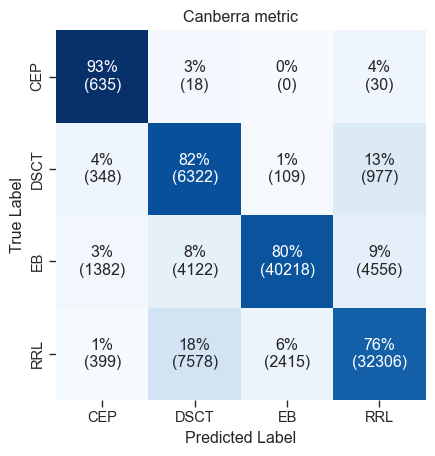

F1 = 63.13 %
Accuracy = 78.37 %
Matthew's Coefficient = 66.25 %


In [11]:
acc = accuracy_score(y, y_pred_test)
f1score = f1_score(y, y_pred_test, average="macro")
matthew_coef = matthews_corrcoef(y, y_pred_test)

ax = utils.plot_cm(y_true=y, y_pred=y_pred_test)
ax.set_title(f"Canberra metric")
plt.show()

print(
    f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
)

In [12]:
check_sigma = 5
outlier_info_by_snid = {}

for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", metric_str)
    print("*" * 20, metric_str, "*" * 20)
    Path(locpath).mkdir(parents=True, exist_ok=True)
    
    lcdc.fit(X, y)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_
    dist_df.index=X_df.index
    mean_distdf = dist_df.mean() # try median
    sig_distdf = dist_df.std() # try iqr
    
    is_outlier_df = (dist_df < (mean_distdf - check_sigma / 2 * sig_distdf)) | (dist_df > (mean_distdf + check_sigma / 2 * sig_distdf))
    row_has_an_outlier = is_outlier_df.all(axis=1) # far away from ALL other classes!
    current_metric_outliers_df = dist_df.loc[row_has_an_outlier] 
    
    # Record which metric flagged which SNID
    for snid_val in current_metric_outliers_df.index:
        outlier_info_by_snid.setdefault(snid_val, []).append(metric_str)
            
    current_metric_outliers_df.to_csv(os.path.join(f"{locpath}/outliers.csv"))

Metric:   0%|          | 0/29 [00:00<?, ?it/s]

******************** Euclidean ********************
******************** Braycurtis ********************
******************** Canberra ********************
******************** Cityblock ********************
******************** Chebyshev ********************
******************** Clark ********************
******************** Correlation ********************
******************** Cosine ********************
******************** Hellinger ********************
******************** Jaccard ********************
******************** Lorentzian ********************
******************** Meehl ********************
******************** Soergel ********************
******************** Wave_Hedges ********************
******************** Kulczynski ********************
******************** Add_Chisq ********************
******************** Acc ********************
******************** Divergence ********************
******************** Google ********************
******************** Jeffreys

In [13]:
# Convert the dictionary of outlier information to a DataFrame
records = []
for snid_val, metrics_list in outlier_info_by_snid.items():
    records.append({'snid': snid_val, 
                    'flagged_by_metrics': metrics_list, 
                    'num_flagging_metrics': len(metrics_list)})

In [14]:
snidflagged = pd.DataFrame(records)
# Sort by the number of flagging metrics (descending), then by snid (ascending for tie-breaking)
snidflagged = snidflagged.sort_values(
    by=['num_flagging_metrics', 'snid'], 
    ascending=[False, True]
).reset_index(drop=True)

In [15]:
records = []
for snid_val, metrics_list in outlier_info_by_snid.items():
    records.append({'snid': snid_val, 
                    'flagged_by_metrics': metrics_list, 
                    'num_flagging_metrics': len(metrics_list)})

# Define expected columns to handle empty 'records' gracefully without an if/else
snidflagged_columns = ['snid', 'flagged_by_metrics', 'num_flagging_metrics']
snidflagged = pd.DataFrame(records, columns=snidflagged_columns)

# Add 'class' column from the 'temp' DataFrame.
# Assumes 'temp' is indexed by SNID and has a 'target' column for class labels.
# Adjust temp['target'] if your class column in 'temp' has a different name,
# or if class information is directly in the 'y' Series (e.g., using y.loc[snid_val] or snidflagged['snid'].map(y)).
snidflagged['class'] = snidflagged['snid'].map(y_df)

# Reorder columns for better readability
# Ensure 'class' is included, handling the case where it might not have been successfully added
final_columns = ['snid', 'class', 'num_flagging_metrics', 'flagged_by_metrics']
snidflagged = snidflagged.reindex(columns=final_columns)


# Sort by the number of flagging metrics (descending), then by snid (ascending for tie-breaking)
# This will work even if snidflagged is empty.
snidflagged = snidflagged.sort_values(
    by=['num_flagging_metrics', 'snid'], 
    ascending=[False, True]
).reset_index(drop=True)

In [16]:
snidflagged["class"].value_counts()

class
EB     589
RRL      4
Name: count, dtype: int64

In [17]:
snidflagged["snid"]

0      127766505
1        5296787
2       18207054
3       38692187
4       49022322
         ...    
588    157792122
589    157936243
590    158910879
591    159305664
592    159446326
Name: snid, Length: 593, dtype: int64

In [18]:
snidflagged["snid"].value_counts() / len(all_metrics)
# Percentage of metrics which flagged it as an outlier

snid
127766505    0.034483
27985074     0.034483
30194999     0.034483
30284382     0.034483
34843740     0.034483
               ...   
149093921    0.034483
149617369    0.034483
152403307    0.034483
154230880    0.034483
159446326    0.034483
Name: count, Length: 593, dtype: float64

In [19]:
outlier_classes = X_df.loc[snidflagged["snid"].to_numpy().ravel()]

In [ ]:
np.argwhere(outlier_classes=="CEP")

In [ ]:
snidflagged.iloc[61]

---

In [ ]:
snid = 56961335

In [ ]:
lcdf = pd.read_parquet("data/Cepheid.parquet")
lcdf=lcdf.set_index("SNID")

In [ ]:
def plot_lc(lcdf, snid):
    chosen_df = lcdf.loc[snid]
    cols = ["MJD", "FLUXCAL", "FLUXCALERR", "BAND", "PHOTFLAG", "ZEROPT"]
    dat = []
    for col in cols:
        if col in cols:
            dat.append(chosen_df.loc[col])
    dat = np.array(dat).T
    lc = pd.DataFrame(data=dat,columns=cols).sort_values(by="MJD")

    for band in "ugrizY":
        lc_band = lc[lc["BAND"] == band]
        plt.errorbar(
            x=lc_band["MJD"],
            y=lc_band["FLUXCAL"],
            yerr=lc_band["FLUXCALERR"],
            fmt="o",
            label=f"{band}",
        )
    plt.xlabel("Time (in days)")
    plt.ylabel("Brightness (flux)")
    plt.legend()
    # plt.title(f"OID {objid} ({cur_cl})")
    # plt.xlim(peak_mjd - 40, peak_mjd + 90)
    # plt.grid()
    # plt.savefig("rawlc_crop.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
plot_lc(lcdf,56961335)